In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
pd.set_option("display.max_rows", None)
pd.set_option('display.max_columns', None)

import os
import sys
import unicodedata
from tqdm import tqdm
import re
import io
import msoffcrypto
from tqdm import tqdm
import json
from collections import OrderedDict, Counter
from itertools import product
from googletrans import Translator

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1)
sns.set_style("white")
sns.set_style("ticks")

import scipy.stats
from sklearn.metrics import auc, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_squared_log_error,mean_absolute_error
from sklearn.multioutput import MultiOutputRegressor
import xgboost as xgb

translator = Translator()
norm_method = 'mean'
# base = 'C:/Users/Antonin_JOLY/Desktop/Projects/Haseko/mansion_fit/mansionfit_2020-10-20.csv'

# Data processing

In [2]:
def reverse_transform(X, tr):
    for name, transfo in enumerate(list(tr[0])):
        if transfo =='Squared':
            X = np.squeeze(np.square(X))
        elif transfo == 'Log':
            X = np.squeeze(np.expm1(X))
        else:
            X = np.squeeze(X)
    return X

def normalization(data,method):
    if method == 'mean':
        # Mean normalization
        x, y = data.mean(), data.std()
        data = (data-x)/y
    elif method == 'minmax':
        # Min-max normalization
        x, y = data.min(), data.max()
        data = (data-x)/(y-x)
    return data, (x.values[0],y.values[0])

def unskew_data(data):
    def process_data(data, idx):
        d = {}
        for i in data.columns:
            method = idx.loc[i,0]
            if method == 'Log':
                d[i] = np.log1p(data[i])
            elif method == 'Squared':
                d[i] = np.sqrt(data[i])
            else:
                d[i] = data[i]
        data_pr = pd.DataFrame(data=d, columns = data.columns)
        data_pr = data_pr.fillna(data_pr.mean())
        return data_pr
    
    data = data.astype(float)

    data_log = pd.DataFrame(np.log1p(data), columns= data.columns)
    data_square = pd.DataFrame(np.sqrt(data), columns= data.columns)

    data_skewness = pd.concat([data.skew(), data_log.skew(), data_square.skew()], axis=1)
    data_skewness.columns = ['Raw','Log','Squared']
    data_min = data_skewness.abs().idxmin(axis=1).to_frame()
    data_unskewed = process_data(data, data_min)
    
    return data_unskewed, data_min

def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# MF input shape

In [17]:
data_dir = '../data/コピーデータ240215_4回目.xls'
pw = "haseko20240215"
unlocked_file = io.BytesIO()

excel_file = msoffcrypto.OfficeFile(open(data_dir, "rb"))
excel_file.load_key(password = pw)
excel_file.decrypt(unlocked_file)
df = pd.read_excel(unlocked_file)

print(df.shape)

df.columns = [unicodedata.normalize('NFKC', s) for s in df.columns]
df.columns = [s+'\n'+str(translator.translate(s, dest='en').text) for s in df.columns]
# df = remove_outliers(df, '面積\narea')

print(df.shape)

df.head(15)

(6175, 12)
(6175, 12)


,NO\nNO,LP名\nLP name,実行年\nExecution,家族F\nFamily F,家族数\nFamily number,年齢\nage,合算後年収\nAnnual income after the sum,合算後年収.1\nAnnual income after the sum .1,借入金額(百万円単位)\nBorrowed amount (million yen units),"物件価格(千円)\nProperty price (1,000 yen)",面積\narea,最新住所\nLatest address
0,100001,マンション中心のLPの案件,2019,ファミリー,3,35,～1000万円,10,15,48000,65.01,さいたま市浦和区 上木崎 １－２－２４ クラッシィハウス浦和上木崎
1,100002,マンション中心のLPの案件,2019,ファミリー,3,34,～1000万円,10,33,48000,65.01,さいたま市浦和区 上木崎 １－２－２４ クラッシィハウス浦和上木崎
2,100003,今回追加したデータ,2019,DINKS,2,36,～800万円,8,30,32980,35.73,さいたま市浦和区 上木崎 １－９－１７ シティインデックス 与野駅前
3,100005,今回追加したデータ,2019,独身,1,48,～400万円,4,25,33780,35.73,さいたま市浦和区 上木崎 １－９－１７ シティインデックス 与野駅前
4,100007,今回追加したデータ,2019,独身,1,42,～500万円,4,28,35980,35.73,さいたま市浦和区 上木崎 １－９－１７ シティインデックス 与野駅前
5,100008,今回追加したデータ,2019,独身,3,29,～500万円,4,18,25880,30.72,さいたま市浦和区 上木崎 １－９－１７ シティインデックス 与野駅前
6,100009,今回追加したデータ,2019,独身,1,51,～400万円,4,24,34480,35.73,さいたま市浦和区 上木崎 １－９－１７ シティインデックス 与野駅前
7,100011,今回追加したデータ,2019,独身,1,33,～500万円,4,31,30900,29.67,さいたま市浦和区 上木崎 １－９－１７ シティインデックス 与野駅前
8,100014,今回追加したデータ,2019,独身,1,42,～500万円,5,27,26580,28.22,さいたま市浦和区 常盤 ３－１４－２ ウィルレーナ浦和常盤
9,100015,今回追加したデータ,2020,独身,1,34,～700万円,7,30,29580,28.84,さいたま市浦和区 常盤 ３－８５－２ ウィルレーナ浦和常盤


In [18]:
df.describe()

,NO\nNO,実行年\nExecution,家族数\nFamily number,年齢\nage,合算後年収.1\nAnnual income after the sum .1,借入金額(百万円単位)\nBorrowed amount (million yen units),"物件価格(千円)\nProperty price (1,000 yen)",面積\narea
count,6175.00000,6175.000000,6175.000000,6175.000000,6175.000000,6175.000000,6175.000000,6175.000000
mean,103515.17085,2021.015870,2.256842,40.492470,10.374899,35.436761,55176.357409,66.977158
std,2029.96791,1.307726,0.995995,7.861609,7.695230,19.965183,29796.125451,652.203327
min,100001.00000,2019.000000,0.000000,22.000000,1.000000,0.000000,20000.000000,18.280000
25%,101750.50000,2020.000000,2.000000,35.000000,6.000000,24.000000,39080.000000,51.200000
50%,103496.00000,2021.000000,2.000000,39.000000,9.000000,34.000000,47980.000000,64.030000
75%,105300.50000,2022.000000,3.000000,45.000000,12.000000,44.000000,61670.000000,68.340000
max,107026.00000,2023.000000,7.000000,72.000000,198.000000,200.000000,426000.000000,51294.000000


In [4]:
# Remove unique address
cnt = Counter(df['最新住所\nLatest address'])
cnt = {k:v for k,v in cnt.items() if v==1}
len(cnt)

327

In [5]:
df_filtered = df.copy()
df_filtered = [df_filtered['家族F\nFamily F']!='独身']
df_filtered = df[['物件価格(千円)\nProperty price (1,000 yen)', '面積\narea', '最新住所\nLatest address']].drop_duplicates()
df_filtered = df.loc[df_filtered.index,:]
print(df_filtered.shape)

df_filtered.head()

(4791, 12)


,NO\nNO,LP名\nLP name,実行年\nExecution,家族F\nFamily F,家族数\nFamily number,年齢\nage,合算後年収\nAnnual income after the sum,合算後年収.1\nAnnual income after the sum .1,借入金額(百万円単位)\nBorrowed amount (million yen units),"物件価格(千円)\nProperty price (1,000 yen)",面積\narea,最新住所\nLatest address
0,100001,マンション中心のLPの案件,2019,ファミリー,3,35,～1000万円,10,15,48000,65.01,さいたま市浦和区 上木崎 １－２－２４ クラッシィハウス浦和上木崎
2,100003,今回追加したデータ,2019,DINKS,2,36,～800万円,8,30,32980,35.73,さいたま市浦和区 上木崎 １－９－１７ シティインデックス 与野駅前
3,100005,今回追加したデータ,2019,独身,1,48,～400万円,4,25,33780,35.73,さいたま市浦和区 上木崎 １－９－１７ シティインデックス 与野駅前
4,100007,今回追加したデータ,2019,独身,1,42,～500万円,4,28,35980,35.73,さいたま市浦和区 上木崎 １－９－１７ シティインデックス 与野駅前
5,100008,今回追加したデータ,2019,独身,3,29,～500万円,4,18,25880,30.72,さいたま市浦和区 上木崎 １－９－１７ シティインデックス 与野駅前


In [ ]:
pair_loan = df_filtered[]

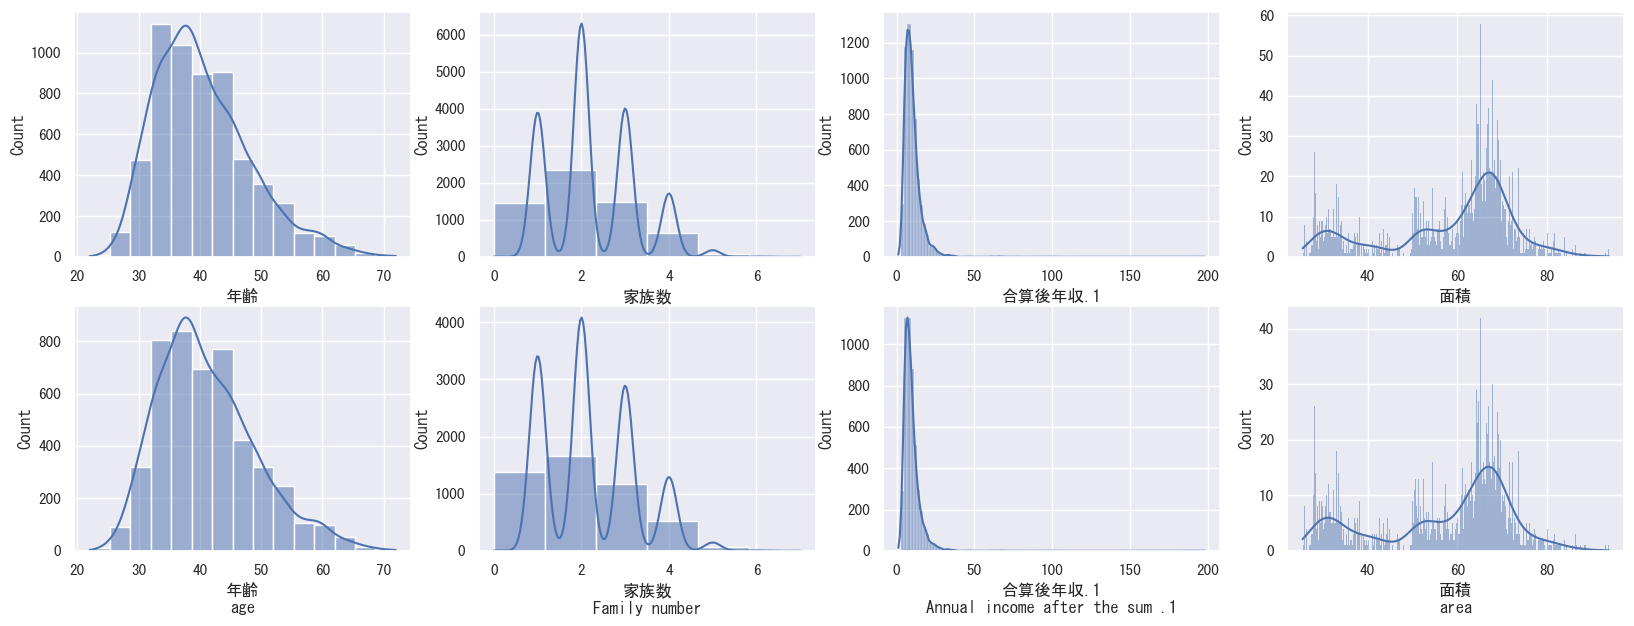

In [6]:
sns.set(font_scale=1.0, font="MS Gothic")
fig,axes = plt.subplots(2, 4, figsize=(20, 7))
sns.histplot(df['年齢\nage'], ax=axes[0,0], kde=True, bins=15)
sns.histplot(df['家族数\nFamily number'], ax=axes[0,1], kde=True, bins=6)
sns.histplot(df['合算後年収.1\nAnnual income after the sum .1'], ax=axes[0,2], kde=True, bins=100)
sns.histplot(df['面積\narea'], ax=axes[0,3], kde=True, bins=1000)

sns.histplot(df_filtered['年齢\nage'], ax=axes[1,0], kde=True, bins=15)
sns.histplot(df_filtered['家族数\nFamily number'], ax=axes[1,1], kde=True, bins=6)
sns.histplot(df_filtered['合算後年収.1\nAnnual income after the sum .1'], ax=axes[1,2], kde=True, bins=100)
sns.histplot(df_filtered['面積\narea'], ax=axes[1,3], kde=True, bins=1000)
sns.set_style("white")
plt.show()

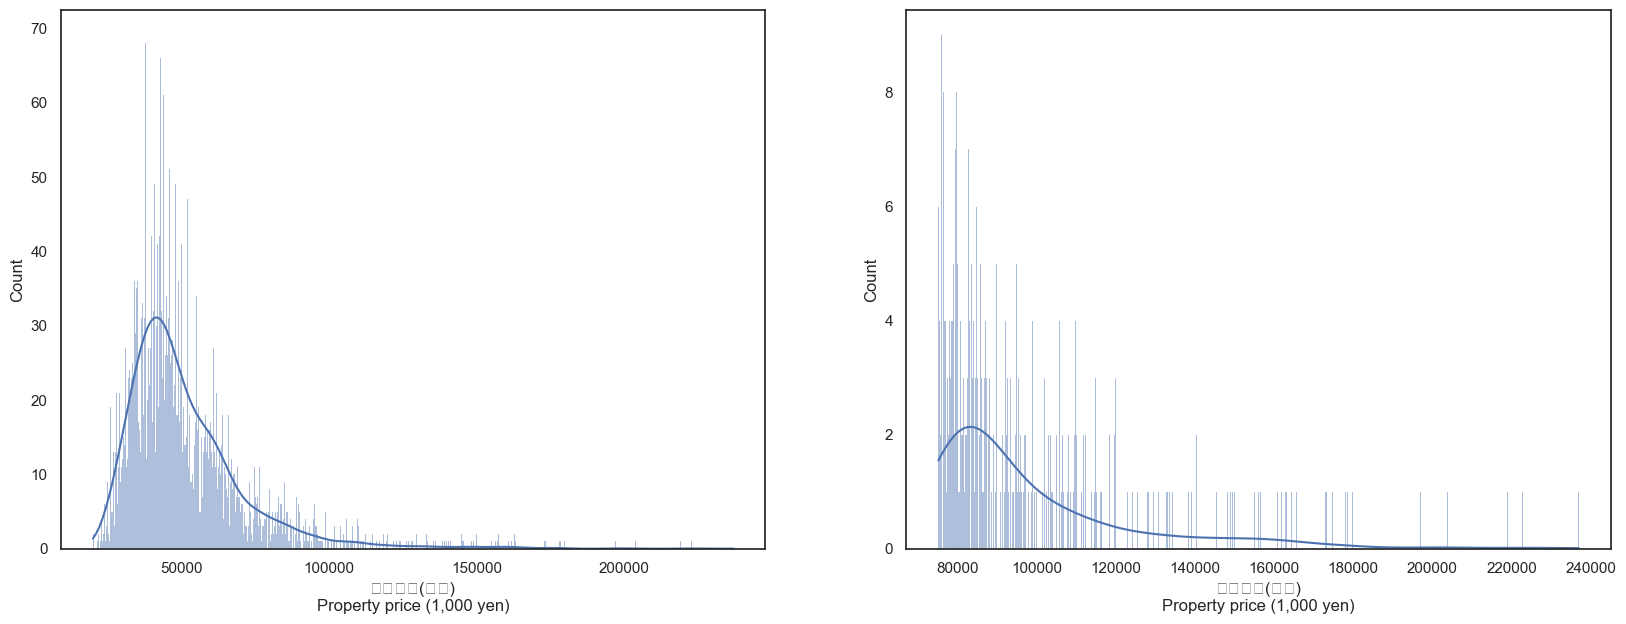

In [7]:
df = df_filtered.copy()
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20, 7))
sns.histplot(df['物件価格(千円)\nProperty price (1,000 yen)'], ax=ax1, kde=True, bins=1000)

df = df[df['物件価格(千円)\nProperty price (1,000 yen)']>75000]
sns.histplot(df['物件価格(千円)\nProperty price (1,000 yen)'], ax=ax2, kde=True, bins=1000)
sns.set_style("white")
sns.set(font_scale=1.0, font="MS Gothic")
plt.show()

In [8]:
continuous_col = ['家族数\nFamily number','年齢\nage','借入金額(百万円単位)\nBorrowed amount (million yen units)']
categorical_col = ['家族F\nFamily F','合算後年収\nAnnual income after the sum'] 

In [9]:
data_continuous, transform_input = unskew_data(df[continuous_col])
data_continuous, (x_in, y_in) = normalization(data_continuous, norm_method)

encoder = OneHotEncoder(dtype=np.int64, sparse=True)
data_categorical = pd.DataFrame(encoder.fit_transform(df[categorical_col]).toarray(),
                                columns = [i for i in encoder.get_feature_names_out()],
                                index = df.index)

data = pd.concat([data_continuous, data_categorical], axis=1)
# filehandler = open("encoder.obj","wb")
# pickle.dump(encoder,filehandler)
# filehandler.close()

In [10]:
transform_input

,0
家族数\nFamily number,Raw
年齢\nage,Log
借入金額(百万円単位)\nBorrowed amount (million yen units),Squared


In [11]:
data.head()

,家族数\nFamily number,年齢\nage,借入金額(百万円単位)\nBorrowed amount (million yen units),家族F\nFamily F_DINKS,家族F\nFamily F_ファミリー,家族F\nFamily F_独身,合算後年収\nAnnual income after the sum_1000万円超,合算後年収\nAnnual income after the sum_～1000万円,合算後年収\nAnnual income after the sum_～400万円,合算後年収\nAnnual income after the sum_～500万円,合算後年収\nAnnual income after the sum_～600万円,合算後年収\nAnnual income after the sum_～700万円,合算後年収\nAnnual income after the sum_～800万円,合算後年収\nAnnual income after the sum_～900万円
62,0.416512,-0.718739,-2.843352,0,1,0,1,0,0,0,0,0,0,0
193,1.448279,0.702842,0.334733,0,1,0,0,0,0,0,0,0,1,0
262,0.416512,0.101012,-0.108897,0,1,0,0,0,0,0,0,1,0,0
273,1.448279,0.587547,0.821771,0,1,0,1,0,0,0,0,0,0,0
276,-0.615254,-2.426317,-0.371960,1,0,0,1,0,0,0,0,0,0,0


array([[<Axes: title={'center': '家族数\nFamily number'}>,
        <Axes: title={'center': '年齢\nage'}>,
        <Axes: title={'center': '借入金額(百万円単位)\nBorrowed amount (million yen units)'}>,
        <Axes: title={'center': '家族F\nFamily F_DINKS'}>],
       [<Axes: title={'center': '家族F\nFamily F_ファミリー'}>,
        <Axes: title={'center': '家族F\nFamily F_独身'}>,
        <Axes: title={'center': '合算後年収\nAnnual income after the sum_1000万円超'}>,
        <Axes: title={'center': '合算後年収\nAnnual income after the sum_～1000万円'}>],
       [<Axes: title={'center': '合算後年収\nAnnual income after the sum_～400万円'}>,
        <Axes: title={'center': '合算後年収\nAnnual income after the sum_～500万円'}>,
        <Axes: title={'center': '合算後年収\nAnnual income after the sum_～600万円'}>,
        <Axes: title={'center': '合算後年収\nAnnual income after the sum_～700万円'}>],
       [<Axes: title={'center': '合算後年収\nAnnual income after the sum_～800万円'}>,
        <Axes: title={'center': '合算後年収\nAnnual income after the sum_～900万円'}>,
        

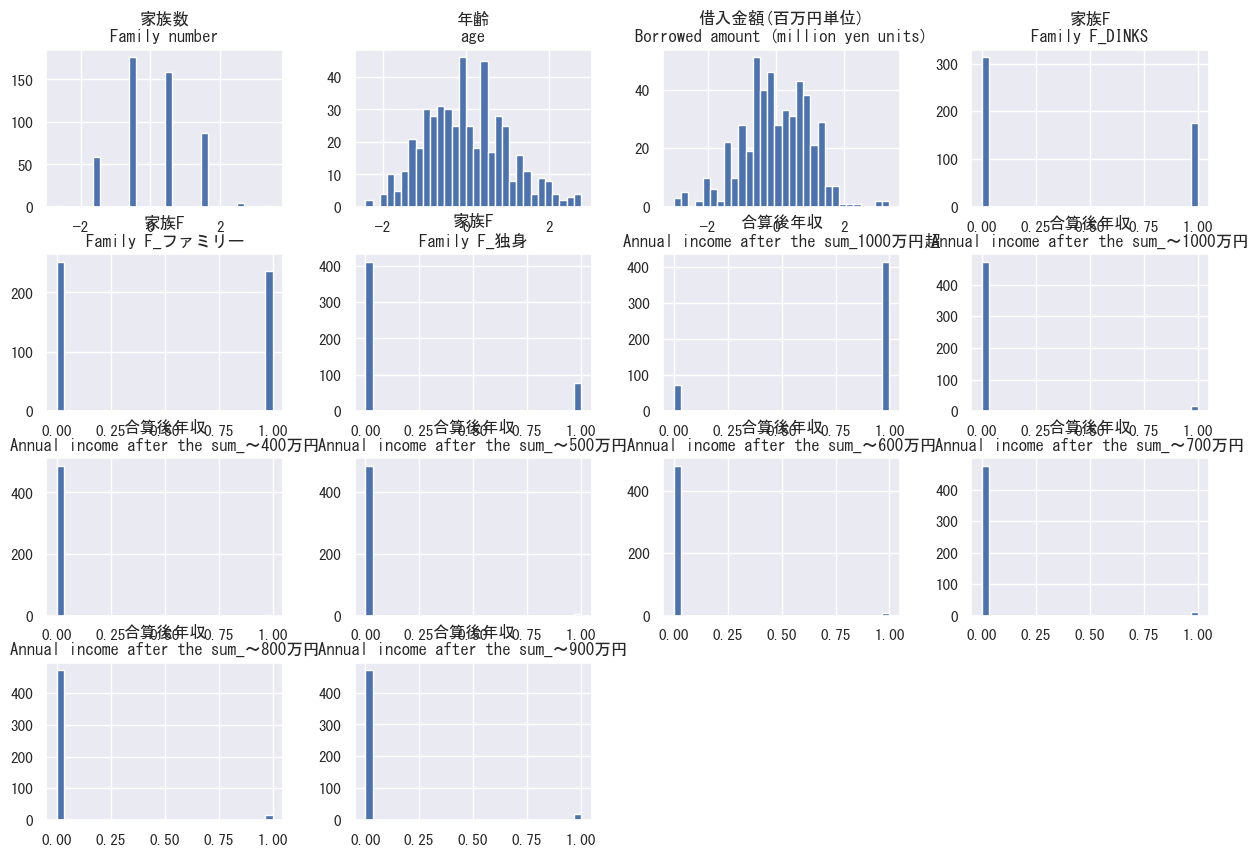

In [13]:
data.hist(bins=30, figsize=(15, 10))
plt.show()

In [12]:
target_col = ['物件価格(千円)\nProperty price (1,000 yen)']
target = df[target_col]

target, transform_output = unskew_data(target)
target, (x_out, y_out) = normalization(target, norm_method)

array([[<Axes: title={'center': '物件価格(千円)\nProperty price (1,000 yen)'}>]],
      dtype=object)

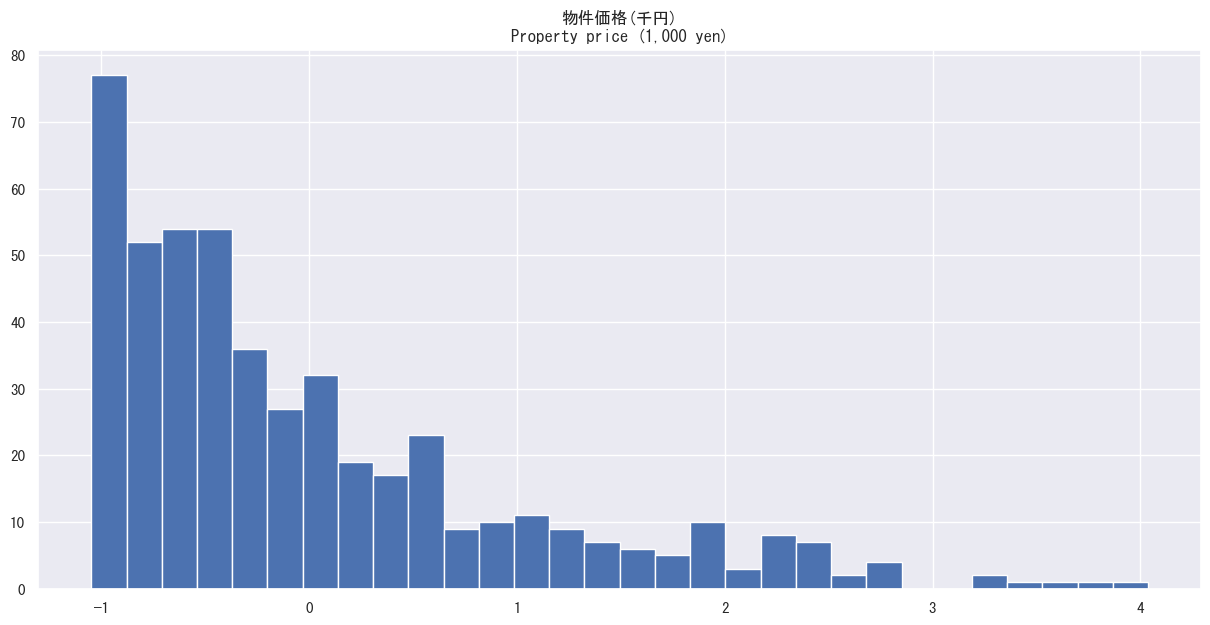

In [14]:
target.hist(bins=30, figsize=(15, 7))
plt.show()